# Varied audience model

In [1]:
import numpy as np
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from model_varied_audience import *

sns.set_context('talk')

- In-group members: vary from 0 to 4
- Out-group members: powers of 2 up to 16

In [2]:
ns_ingroup = [0, 1, 2, 3, 4]
ns_outgroup = [0, 1, 2, 4, 8, 16]

# list of [ingroup, outgroup] possibilites
ns = [[i, o] for i in ns_ingroup for o in ns_outgroup]

Generate model predictions, populate into a dataframe

In [3]:
rows = []
for n in ns: 
    pred_refer = speaker(n_ingroup=n[0], n_outgroup=n[1], alpha=2, w_r=1, w_s=0, w_c=0.05)
    rows.append({'goal': 'refer', 'n_ingroup': n[0], 'n_outgroup': n[1], 'p_earlier': pred_refer[0]})

    pred_social = speaker(n_ingroup=n[0], n_outgroup=n[1], alpha=2, w_r=1, w_s=1, w_c=0.05)
    rows.append({'goal': 'social', 'n_ingroup': n[0], 'n_outgroup': n[1], 'p_earlier': pred_social[0]})

df = pd.DataFrame(rows)

# remove jax stuff
df['p_earlier'] = df['p_earlier'].apply(lambda x: x.item())

In [4]:
df

,goal,n_ingroup,n_outgroup,p_earlier
0,refer,0,0,0.475021
1,social,0,0,0.475021
2,refer,0,1,0.869892
3,social,0,1,0.869892
4,refer,0,2,0.980160
5,social,0,2,0.980160
6,refer,0,4,0.999629
7,social,0,4,0.999629
8,refer,0,8,1.000000
9,social,0,8,1.000000


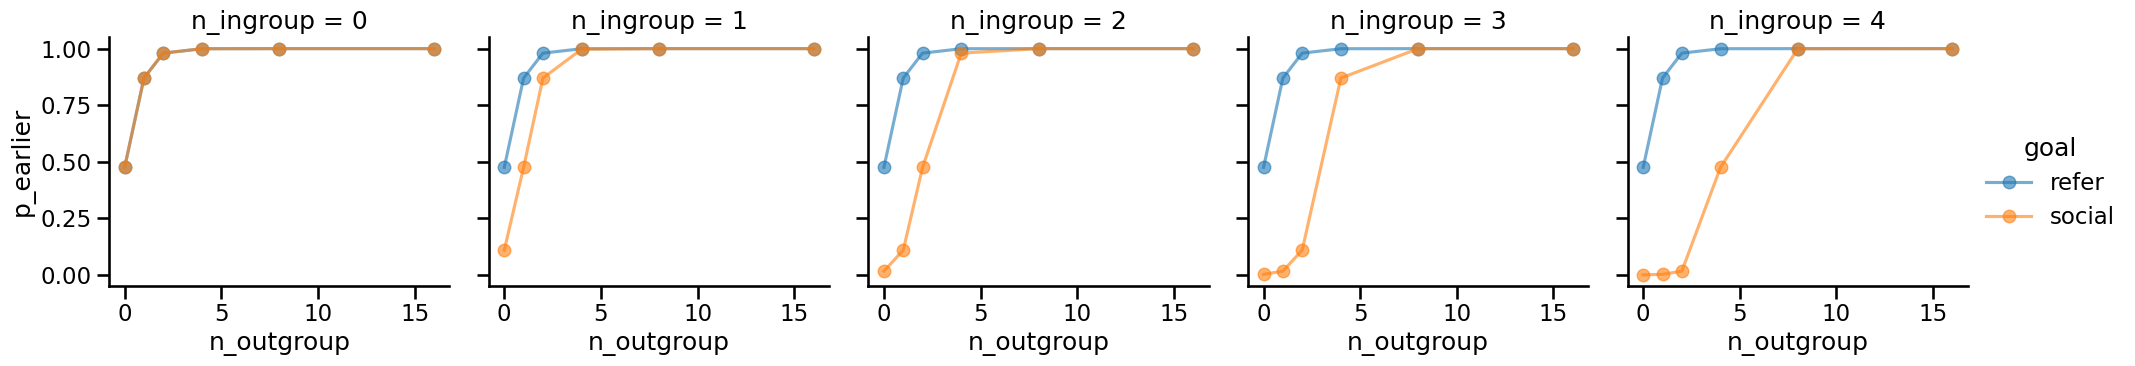

In [5]:
g = sns.FacetGrid(df, col='n_ingroup', hue="goal", col_wrap=5, height=4)
g.map(plt.plot, 'n_outgroup', 'p_earlier', marker='o', alpha= 0.6)
g.add_legend()

Plots with proportion

In [6]:
df['n_total'] = df['n_ingroup'] + df['n_outgroup']
df['prop_ingroup'] = df['n_ingroup'] / df['n_total']

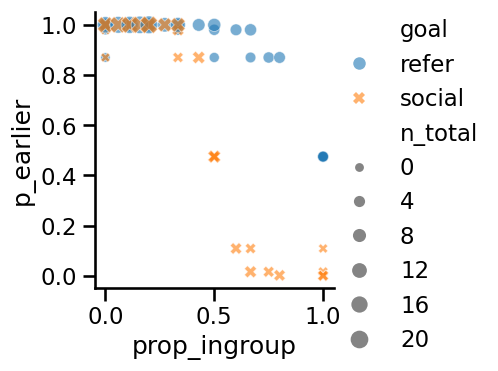

In [7]:
g = sns.relplot(data=df, x='prop_ingroup', y='p_earlier', hue='goal', style="goal", size="n_total", alpha=0.6, height=4)

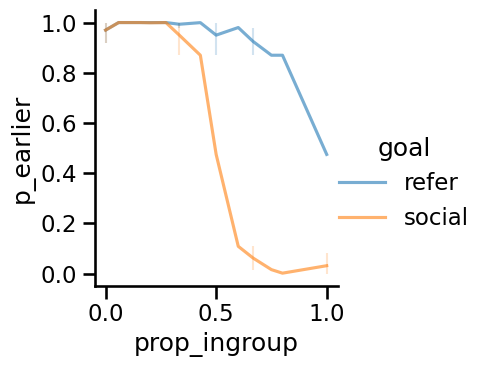

In [8]:
g = sns.relplot(data=df, x='prop_ingroup', y='p_earlier', hue='goal', kind='line', alpha=0.6, height=4)